"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [1]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
from theano.tensor.extra_ops import cumsum

[ 96 346]
[  0  96 346 500]
[[0.93420082 0.24430034 0.77020769]
 [0.37244707 0.32415477 0.36117079]
 [0.19714366 0.93079133 0.960433  ]
 [0.50944785 0.04461311 0.90467841]
 [0.43406519 0.2953706  0.68176282]]
(5, 500)


/tmp/ipykernel_7722/2586445778.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  true_tau = np.vectorize(np.int)(true_tau)
/tmp/ipykernel_7722/2586445778.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumP

Text(0, 0.5, 'Spikes')

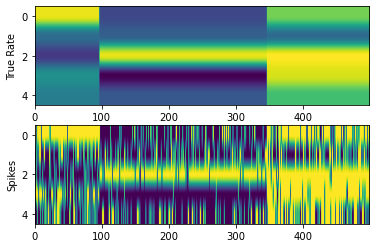

In [2]:
# Some poisson spiking
length = 500
states = 3
nrns = 5
fit = int(1e4)
samples = 2000
idx = np.arange(length)

true_tau = np.cumsum(np.random.random(states))
true_tau /= np.max(true_tau)
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)
state_inds = np.concatenate([np.zeros((1)),true_tau])
state_inds = np.vectorize(np.int)(state_inds)
true_tau = true_tau[:-1]

true_lambda = np.random.random((nrns,states))

print(true_tau)
print(state_inds)
print(true_lambda)

true_r = np.zeros((nrns,length))
for num, val in enumerate(true_lambda.T):
    true_r[:,state_inds[num]:state_inds[num+1]] = val[:,np.newaxis]
  
data_vec = np.random.random((nrns,length)) < true_r
print(data_vec.shape)
#data_vec = np.random.poisson(true_r)

fig,ax = plt.subplots(2,1)
ax[0].imshow(true_r,aspect='auto')
ax[1].imshow(data_vec,aspect='auto')
ax[0].set_ylabel("True Rate")
ax[1].set_ylabel("Spikes")

In [3]:
mean_vals = np.array([np.mean(x,axis=-1) for x in np.array_split(data_vec,states,axis=-1)]).T
print(mean_vals)

[[0.61676647 0.28143713 0.72891566]
 [0.33532934 0.29341317 0.40361446]
 [0.49101796 0.93413174 0.95783133]
 [0.34730539 0.0239521  0.84337349]
 [0.36526946 0.28143713 0.64457831]]


In [4]:
with pm.Model() as model:
    # Finite, but somewhere on the lower end, Beta prior
    a_lambda = 2
    b_lambda = 5
    lambda_latent = pm.Beta('lambda', 
                                    a_lambda, b_lambda, 
                                    shape = (nrns,states),
                                  testval = mean_vals + 1e-3)

    a = pm.HalfCauchy('a_tau', 3., shape = states - 1)
    b = pm.HalfCauchy('b_tau', 3., shape = states - 1)
    
    even_switches = np.linspace(0,1,states+1)[1:-1]
    tau_latent = pm.Beta('tau_latent', a, b, 
                         testval = even_switches,
                         shape = (states-1))
    tau_latent_sort = pm.Deterministic('tau_sort', tau_latent.sort())
    
    #tau_latent_ind = pm.Beta('tau_latent_ind', mu = tau_latent, sigma = 0.1,
    #                        shape = (nrns,states-1))#.sort(axis=-1)
    #tau_latent_ind = pm.TruncatedNormal('tau_latent_ind', mu = tau_latent, sigma = 0.1,
    #                        lower = 0, upper = 1, shape = (nrns,states-1)).sort(axis=-1)
    #tau_latent_ind = tt.stack(
    #                [pm.Beta(f'tau_latent_ind{ind}', 
    #                         mu = tau_latent[ind], sigma = 0.1,
    #                            shape = nrns) \
    #                 for ind in range(states-1)],axis=-1)
    
    tau_diff = pm.Normal('tau_diff', mu = 0, sigma = 0.1, shape = states-1)
    tau_diff_raw = pm.Normal('diff_raw', mu = tau_diff, sigma = 0.1,
                            shape = (nrns, states-1))
    #trans_chain = pm.distributions.transforms.Chain(
    #                            [pm.distributions.transforms.LowerBound(0),
    #                                  pm.distributions.transforms.UpperBound(1)])
    tau_latent_raw = tau_latent_sort + tau_diff_raw
    tau_latent_lower = tt.maximum(np.zeros((nrns, states-1)), tau_latent_raw)
    tau_latent_fin = tt.minimum(np.ones((nrns, states-1)), tau_latent_raw)
                                     #transform = trans_chain)
    #tau_latent_fin = pm.Bound(tau_latent_raw, lower = 0, upper = 1)

    tau = pm.Deterministic('tau', 
            idx.min() + (idx.max() - idx.min()) * tau_latent_fin)

In [5]:
tau_latent_raw.tag.test_value

array([[0.33333333, 0.66666667],
       [0.33333333, 0.66666667],
       [0.33333333, 0.66666667],
       [0.33333333, 0.66666667],
       [0.33333333, 0.66666667]])

In [6]:
print(tau.tag.test_value.shape)
print(idx.shape)

(5, 2)
(500,)


In [7]:
tau_latent.tag.test_value

array([0.33333333, 0.66666667])

In [8]:
#tau_latent_ind.tag.test_value

In [9]:
with model:
    weight_stack = tt.nnet.sigmoid(idx[np.newaxis,np.newaxis,:]-tau[:,:,np.newaxis]) # nrns x changes x time
    #weight_stack = tt.nnet.sigmoid(idx[np.newaxis,:]-tau[:,np.newaxis])
    weight_stack = tt.concatenate([np.ones((nrns,1,length)),weight_stack],axis=1)
    #weight_stack = tt.concatenate([np.ones((1,length)),weight_stack],axis=0)
    inverse_stack = 1 - weight_stack[:,1:]
    inverse_stack = tt.concatenate([inverse_stack, np.ones((nrns,1,length))],axis=1)
    weight_stack = np.multiply(weight_stack,inverse_stack)

In [10]:
with model:
    #lambda_ = lambda_latent.dot(weight_stack)
    #lambda_ = tt.tensordot(lambda_latent[:,:,np.newaxis], weight_stack,axes=1)
    lambda_ = tt.sum(lambda_latent[:,:,np.newaxis]* weight_stack,axis=1)

(5, 500)


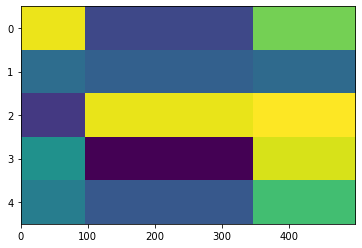

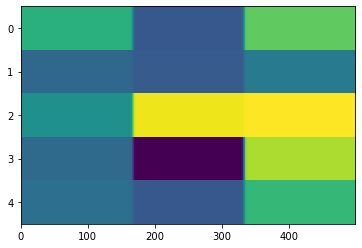

In [11]:
plt.imshow(true_r,aspect='auto', interpolation='nearest')
plt.figure()
plt.imshow(lambda_.tag.test_value, aspect='auto', interpolation='nearest')
print(lambda_.tag.test_value.shape)

In [12]:
# with model:
#     prior_checks = pm.sample_prior_predictive(samples=50)

In [13]:
with model:
    # Add observations
    observation = pm.Bernoulli("obs", lambda_, observed=data_vec)

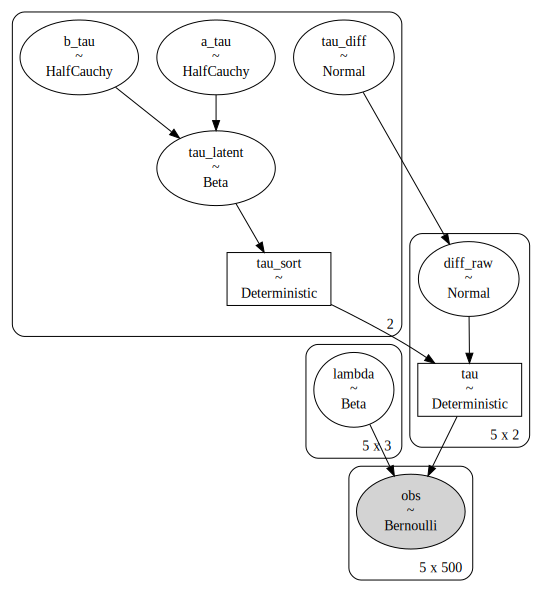

In [14]:
pm.model_to_graphviz(model)

In [15]:
with model:
    #trace = pm.sample(step=pm.Slice())
    trace = pm.sample(step=pm.Metropolis(), draws = 5000, tune = 1000, chains = 8, cores = 8)
#     inference = pm.ADVI('full-rank')
#     approx = pm.fit(n=fit, method=inference,
#                    random_seed = 3,
#                    obj_n_mc = 1)
#     trace = approx.sample(draws=samples)

/tmp/ipykernel_7722/2374795575.py:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(step=pm.Metropolis(), draws = 5000, tune = 1000, chains = 8, cores = 8)
Multiprocess sampling (8 chains in 8 jobs)
CompoundStep
>Metropolis: [diff_raw]
>Metropolis: [tau_diff]
>Metropolis: [tau_latent]
>Metropolis: [b_tau]
>Metropolis: [a_tau]
>Metropolis: [lambda]


Sampling 8 chains for 1_000 tune and 5_000 draw iterations (8_000 + 40_000 draws total) took 18 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


/tmp/ipykernel_7722/2188298374.py:3: DeprecationWarning: The function `autocorrplot` from PyMC3 is just an alias for `plot_autocorr` from ArviZ. Please switch to `pymc3.plot_autocorr` or `arviz.plot_autocorr`.
  pm.autocorrplot(trace['tau'][::thinning,0,0])#, var_names = ['tau']);


<AxesSubplot:title={'center':'x\n0'}>

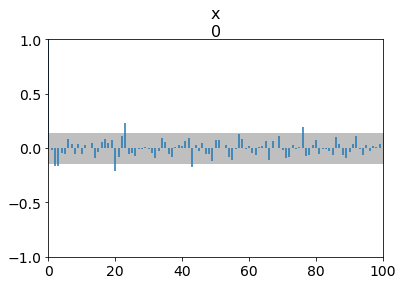

In [16]:
thinning = 200
#pm.autocorrplot(trace['tau'][::thinning,0,0]);
pm.autocorrplot(trace['tau'][::thinning,0,0])#, var_names = ['tau']);

In [17]:
fin_trace = trace[::thinning]

/tmp/ipykernel_7722/210878834.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(fin_trace);
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


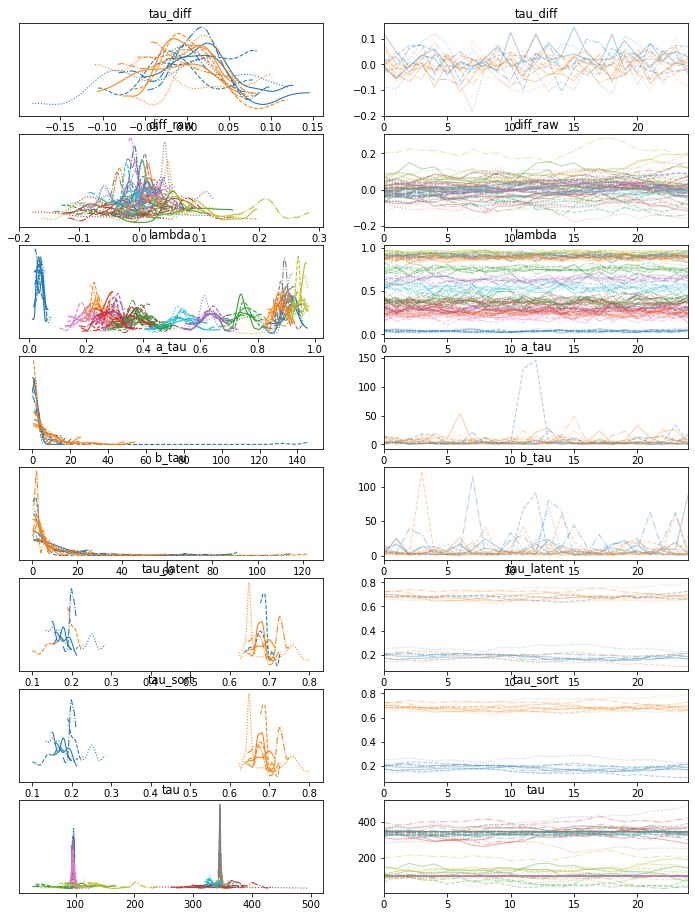

In [18]:
pm.traceplot(fin_trace);

In [19]:
# fig,ax = plt.subplots(1,2,figsize=(15,5))
# ax[0].plot(-approx.hist, alpha=.3)
# ax[0].set_ylabel('ELBO')
# ax[0].set_xlabel('iteration');

# ind = int(fit - fit*0.05)
# ax[1].plot(-approx.hist[ind:], alpha=.3)
# ax[1].set_title('Final 5% of iterations')
# ax[1].set_ylabel('ELBO')
# ax[1].set_xlabel('iteration');

In [20]:
ppc = pm.sample_posterior_predictive(fin_trace, samples = 2000, model = model)

Text(0.5, 1.0, 'Mean prediction')

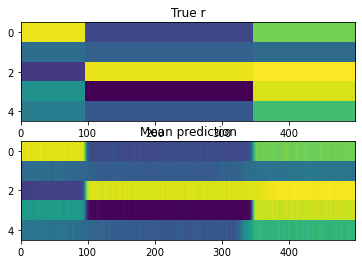

In [21]:
fig,ax = plt.subplots(2,1,sharey=True)
ax[0].imshow(true_r,aspect='auto', interpolation='nearest')
ax[1].imshow(np.mean(ppc['obs'],axis=0), aspect='auto', interpolation='nearest')
ax[0].set_title('True r')
ax[1].set_title('Mean prediction')

In [22]:
#min_val,max_val = min(true_r),max(true_r)
tau = fin_trace['tau']
print(tau.shape)
mode_tau = np.mean(np.vectorize(np.int)(tau),axis=0)
print(mode_tau.shape)

(200, 5, 2)
(5, 2)


/tmp/ipykernel_7722/2176164199.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mode_tau = np.mean(np.vectorize(np.int)(tau),axis=0)


In [23]:
agg_tau = fin_trace['tau_sort']
agg_tau_scaled = idx.min() + (idx.max() - idx.min()) * agg_tau
print(agg_tau_scaled.shape)

(200, 2)


In [24]:
mode_agg_tau = np.mean(np.vectorize(np.int)(agg_tau_scaled),axis=0)
mode_agg_tau

/tmp/ipykernel_7722/2854850056.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mode_agg_tau = np.mean(np.vectorize(np.int)(agg_tau_scaled),axis=0)


array([ 92.405, 342.68 ])

In [25]:
tau.shape

(200, 5, 2)

In [26]:
#inds = np.array(list(np.ndindex(tau.shape[1:])))
bins = np.linspace(idx.min(),idx.max(),50)
tau_hists = np.array([[np.histogram(tau[:,nrn,change], bins)[0] 
              for nrn in range(tau.shape[1])] for change in range(tau.shape[2])])
tau_hists.shape

(2, 5, 49)

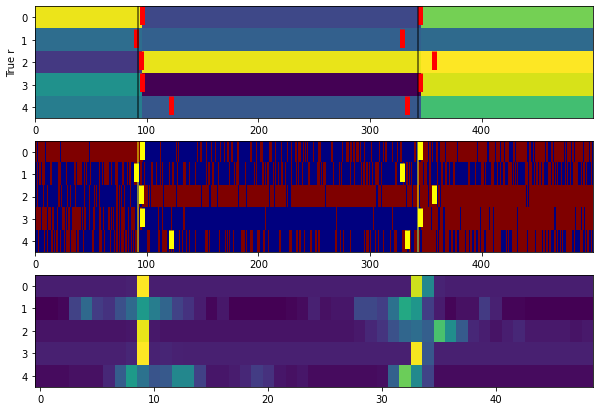

In [28]:
fig,ax = plt.subplots(3,1,sharex=False,figsize=(10,7))
ax[0].imshow(true_r,aspect='auto', interpolation='nearest')
ax[0].set_ylabel('True r')
ax[1].imshow(data_vec,aspect='auto', cmap = 'jet', interpolation='nearest')
    
# for tau_num, this_tau in enumerate(tau.T):
#     ax[2].hist(this_tau,bins=50)
#     ax[0].vlines(mode_tau[tau_num],-0.5,nrns-0.5,color='red',alpha=1,linewidth=5, linestyles='dashed')
for this_agg in mode_agg_tau:
    ax[0].axvline(this_agg, color = 'k', linewidth = 2, alpha = 0.5)
    ax[1].axvline(this_agg, color = 'yellow', linewidth = 2, alpha = 0.5)
for nrn_num, this_tau in enumerate(mode_tau):
    #ax[2].hist(this_tau,bins=50)
    ax[0].vlines(this_tau,nrn_num-0.5,nrn_num+0.5,color='red',alpha=1,linewidth=5, linestyles='dashed')
    ax[1].vlines(this_tau,nrn_num-0.5,nrn_num+0.5,color='yellow',alpha=1,linewidth=5, linestyles='dashed')
ax[2].imshow(np.sum(stats.zscore(tau_hists,axis=-1),axis=0), aspect='auto')